TODO:

- [x] Validate the duration of the audio files
* Process the audio files and inspect for audio quality
* Analyze duration per image

In [1]:
# %pip install "git+https://github.com/aliutkus/speechmetrics#egg=speechmetrics[cpu]"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import traceback
from pathlib import Path

import librosa
import pandas as pd
import numpy as np
import seaborn as sn
import speechmetrics as sm
from tqdm.auto import tqdm

sys.path.append("..")
from sgs_utils.path_conf import (
    loc_data_dir,
    speech_data_root_dir,
    interim_speech_data_dir,
)
from sgs_utils.speech_metrics import srmr

speech_data_session_dir = speech_data_root_dir.joinpath("backup")

pd.options.display.max_rows = 80
pd.options.display.max_columns = None


ModuleNotFoundError: No module named 'sgs_utils'

In [ ]:
df_session = pd.read_parquet(loc_data_dir.joinpath("df_session_tot_cleaned.parquet"))


## Extracting the metrics

In [6]:
metrics = sm.load("absolute", window=2)


: 

: 

In [ ]:
def get_metric_dict(r: pd.Series):
    if r.wav_duration_s < 5:
        return {}
    try:
        # We will extract the speech metrics on the 16kHz 32-bit float WAV audio
        wav_path: Path = list(
            (interim_speech_data_dir / "full_dur_16khz").glob(
                f"*{r.ID}/{r.DB}/{r.pic_name}__{r.time_str}.wav"
            )
        )[0]
        metric_dict = metrics(str(wav_path), rate=r.wav_sample_rate)

        metric_dict = {
            f"{k}_{i}": v[i] for k, v in metric_dict.items() for i in range(len(v))
        }

        # will be used to merge
        metric_dict["ID"] = r.ID
        metric_dict["DB"] = r.DB
        metric_dict["time_str"] = r.time_str

        # also use the SRMR form srmrpy
        # wav, sr = np.load(wav_path.parent / (wav_path.stem + ".npy")).ravel(), 16_000
        # metric_dict["srmrpy"] = srmr(wav, sr)
    except:
        traceback.print_exc()
    return {}




In [ ]:
metric_dict_list = []
for _, r in tqdm(df_session.iterrows(), total=len(df_session)):
    metric_dict_list.append(get_metric_dict(r))
    break

  0%|          | 0/3257 [00:00<?, ?it/s]

In [17]:
df_metric = pd.DataFrame(metric_dict_list)
# del wav_path, metric_dict, metric_list, r

df_metric.to_parquet(loc_data_dir.joinpath("df_metric_2s.parquet"))


## Analyzing the metrics

In [7]:
df_metric_2s = pd.read_parquet(loc_data_dir.joinpath("df_metric_2s.parquet"))
df_metric_5s = pd.read_parquet(loc_data_dir.joinpath("df_metric_5s.parquet"))


In [19]:
df_metric["nb_metrics"] = df_metric.filter(like="srmr_").apply(
    lambda x: sum(x.notna()), axis=1
)


In [20]:
df_session_metric = pd.merge(
    df_session, df_metric, on=["ID", "DB", "time_str"], how="left"
)


KeyError: 'ID'

In [ ]:
df_session_metric["wav_metric_ratio"] = (
    df_session_metric["wav_duration_s"] / df_session_metric["nb_metrics"]
)


It appears we have a metric each 5s of data

<AxesSubplot:ylabel='Frequency'>

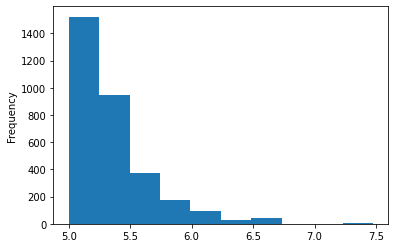

In [ ]:
df_session_metric[df_session_metric.wav_duration_s > 10].wav_metric_ratio.plot.hist()


<AxesSubplot:ylabel='Frequency'>

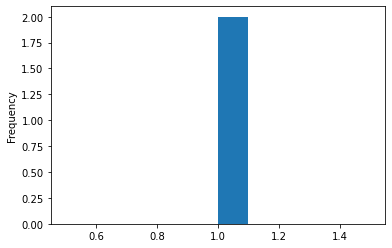

In [ ]:
df_session_metric[
    (df_session_metric.wav_duration_s > 5) & (df_session_metric.wav_duration_s < 9.9)
].nb_metrics.plot.hist()


<AxesSubplot:ylabel='Frequency'>

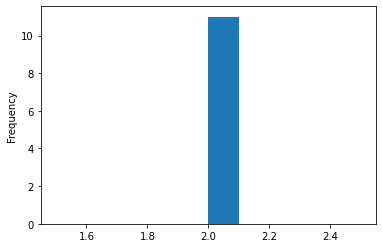

In [ ]:
df_session_metric[
    (df_session_metric.wav_duration_s > 10) & (df_session_metric.wav_duration_s < 15)
].nb_metrics.plot.hist()


### mosnet

<AxesSubplot:ylabel='Density'>

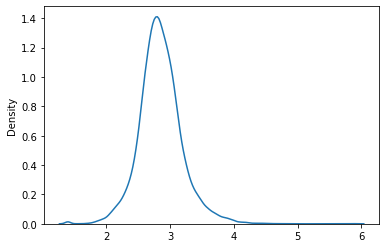

In [ ]:
sn.kdeplot(df_metric.filter(like="mosnet").values.ravel())


<AxesSubplot:ylabel='Density'>

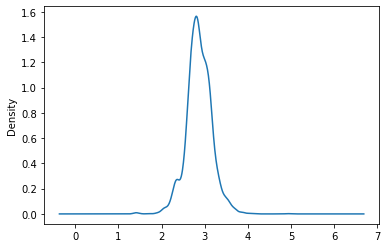

In [ ]:
df_metric.filter(like="mosnet").mean(axis=1).plot.kde()


<AxesSubplot:ylabel='Density'>

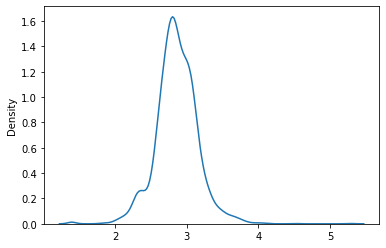

In [ ]:
sn.kdeplot(df_metric.filter(like="mosnet").median(axis=1))


<AxesSubplot:ylabel='Density'>

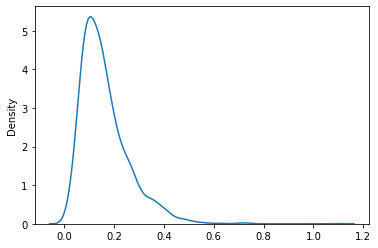

In [ ]:
sn.kdeplot(df_metric.filter(like="mosnet").std(axis=1))


### srmr

<AxesSubplot:ylabel='Density'>

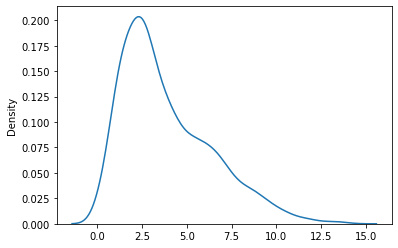

In [ ]:
sn.kdeplot(df_metric.filter(like="srmr_").min(axis=1))


<AxesSubplot:ylabel='Density'>

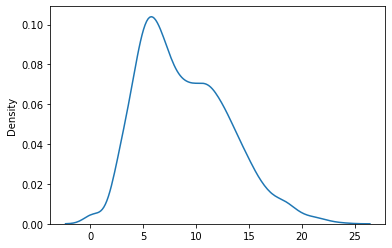

In [ ]:
sn.kdeplot(
    df_metric[df_metric.filter(like="srmr_").max(axis=1) < 25]
    .filter(like="srmr")
    .max(axis=1)
)


<AxesSubplot:ylabel='Density'>

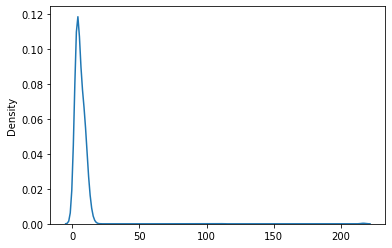

In [ ]:
sn.kdeplot(df_metric.filter(like="srmr_").median(axis=1))


### Alternative srmr implementation

<AxesSubplot:xlabel='srmrpy', ylabel='Density'>

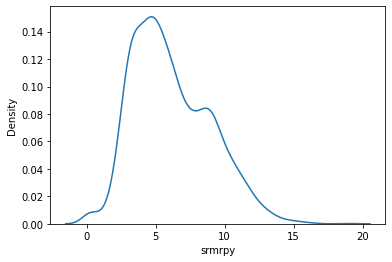

In [ ]:
sn.kdeplot(df_metric["srmrpy"])


In [ ]:
from scipy.stats import pearsonr


In [ ]:
nan_mask = df_metric.filter(like="srmrpy").isna().any(axis=1)


In [ ]:
pearsonr(
    df_metric[~nan_mask]["srmrpy"].values,
    df_metric[~nan_mask].filter(like="srmr_").min(axis=1).values,
)


(0.6434067868513174, 0.0)

In [ ]:
pearsonr(
    df_metric[~nan_mask]["srmrpy"].values,
    df_metric[~nan_mask].filter(like="srmr_").mean(axis=1).values,
)


(0.28812096625801936, 5.410514388931635e-62)

## Filtering df session metric

In [ ]:
df_session_metric[
    (df_session_metric.wav_duration_s > 15)
    & (df_session_metric["srmrpy"] < 0.8)
    & ~(
        (df_session_metric.filter(like="mosnet").mean(axis=1) < 2)
        | (df_session_metric.filter(like="mosnet").min(axis=1) < 1.5)
        | (df_session_metric.filter(like="srmr_").median(axis=1) < 0.5)
    )
][["ID", "timestamp", "DB", "pic_name", "time_str", "srmrpy", "wav_duration_s"]]


,ID,timestamp,DB,pic_name,time_str,srmrpy,wav_duration_s
2725,d7fbc4b9-5f94-4639-b82b-6b1592b2ad3a,2022-06-29 19:34:02.048344+02:00,Radboud,Rafd090_02_Caucasian_female_neutral_frontal,19:52:41,0.716819,41.81


In [ ]:
df_session_metric[
    (df_session_metric.wav_duration_s > 15)
    & ~(
        (df_session_metric.filter(like="mosnet").mean(axis=1) < 2)
        | (df_session_metric.filter(like="mosnet").min(axis=1) < 1.5)
        | (df_session_metric.filter(like="srmr_").median(axis=1) < 0.5)
        | (df_session_metric.filter(like="srmr_").quantile(q=0.3, axis=1) < 0.7)
        | (df_session_metric["srmrpy"] < 0.8)
    )
][["ID", "timestamp", "DB", "pic_name", "time_str", "srmrpy", "wav_duration_s"]]


,ID,timestamp,DB,pic_name,time_str,srmrpy,wav_duration_s
0,099ceb4d-28f3-4b1f-8f8e-16b439a882f1,2022-06-27 16:42:13.679102+02:00,marloes,marloes,16:53:49,9.101357,24.41
1,099ceb4d-28f3-4b1f-8f8e-16b439a882f1,2022-06-27 16:42:13.679102+02:00,PiSCES,Picture 132,16:54:45,6.146323,44.29
2,099ceb4d-28f3-4b1f-8f8e-16b439a882f1,2022-06-27 16:42:13.679102+02:00,Radboud,Rafd090_01_Caucasian_female_neutral_frontal,16:56:01,5.427415,62.55
3,099ceb4d-28f3-4b1f-8f8e-16b439a882f1,2022-06-27 16:42:13.679102+02:00,PiSCES,Picture 56,16:57:23,11.052991,71.59
4,099ceb4d-28f3-4b1f-8f8e-16b439a882f1,2022-06-27 16:42:13.679102+02:00,Radboud,Rafd090_36_Caucasian_male_neutral_frontal,16:58:30,8.501714,56.75
...,...,...,...,...,...,...,...
3189,fb807c80-22cc-4964-81a0-8c732f572004,2020-12-14 16:26:16.730052+01:00,PiSCES,Picture 80,17:21:28,6.713475,54.95
3190,fb807c80-22cc-4964-81a0-8c732f572004,2020-12-14 16:26:16.730052+01:00,Radboud,Rafd090_36_Caucasian_male_neutral_frontal,17:22:45,6.780104,54.36
3191,fb807c80-22cc-4964-81a0-8c732f572004,2020-12-14 16:26:16.730052+01:00,PiSCES,Picture 105,17:23:56,6.455510,55.21
3192,fb807c80-22cc-4964-81a0-8c732f572004,2020-12-14 16:26:16.730052+01:00,Radboud,Rafd090_01_Caucasian_female_neutral_frontal,17:25:03,6.658691,57.09


In [ ]:
df_session_metric[
    (df_session_metric.wav_duration_s > 15)
    & (df_session_metric["srmrpy"] > 15)
    & ~(
        (df_session_metric.filter(like="mosnet").mean(axis=1) < 2)
        | (df_session_metric.filter(like="mosnet").min(axis=1) < 1.5)
        | (df_session_metric.filter(like="srmr_").median(axis=1) < 0.5)
    )
][["ID", "timestamp", "DB", "pic_name", "time_str", "srmrpy", "wav_duration_s"]]


,ID,timestamp,DB,pic_name,time_str,srmrpy,wav_duration_s
919,46914c9d-f87b-4ee5-aaf4-fe30d0ec272a,2020-11-29 13:06:54.379871+01:00,Radboud,Rafd090_46_Caucasian_male_neutral_frontal,13:20:31,15.610187,42.82
920,46914c9d-f87b-4ee5-aaf4-fe30d0ec272a,2020-11-29 13:06:54.379871+01:00,PiSCES,Picture 59,13:21:45,16.434108,65.11
945,46914c9d-f87b-4ee5-aaf4-fe30d0ec272a,2020-11-29 13:06:54.379871+01:00,Radboud,Rafd090_33_Caucasian_male_neutral_frontal,13:52:36,15.797164,38.73
1585,8f42a931-7bd1-4536-bec3-a5f24da3c61f,2020-12-07 19:47:48.102483+01:00,Radboud,Rafd090_05_Caucasian_male_neutral_frontal,20:05:41,15.940446,55.30
2282,b55d08fb-30f3-499f-8cf4-f0f44321f1a9,2020-11-27 16:37:41.186737+01:00,Radboud,Rafd090_47_Caucasian_male_neutral_frontal,16:53:37,15.032920,45.14
2963,effe47df-0f91-489d-8b7d-547f6fed85dd,2022-07-16 20:29:30.890814+02:00,Radboud,Rafd090_33_Caucasian_male_neutral_frontal,21:24:56,15.018271,50.62
2967,effe47df-0f91-489d-8b7d-547f6fed85dd,2022-07-16 20:29:30.890814+02:00,marloes,marloes,21:29:04,15.245146,27.96
3093,f57eb3a1-bc73-4fb8-9c40-8a31a6b67e34,2020-12-01 17:28:08.651479+01:00,PiSCES,Picture 80,17:36:40,18.861273,27.65


# TODO -> the srmr needs to be adjusted

In [ ]:
df_session_metric[
    # (df_session_metric.wav_duration_s > 8) &
    ~(
        (df_session_metric.filter(like="mosnet").mean(axis=1) < 2)
        | (df_session_metric.filter(like="mosnet").min(axis=1) < 1.5)
        | (df_session_metric.filter(like="srmr_").median(axis=1) < 0.5)
    )
][["ID", "timestamp", "DB", "pic_name", "time_str"]]


,ID,timestamp,DB,pic_name,time_str
2731,d7fbc4b9-5f94-4639-b82b-6b1592b2ad3a,2022-06-29 19:34:02.048344+02:00,PiSCES,Picture 80,19:57:47


<AxesSubplot:>

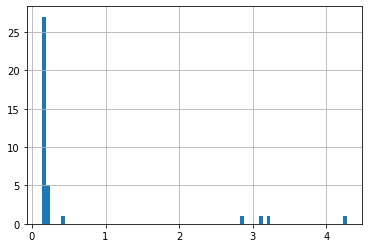

In [ ]:
# a lot of silent / no audio sessions
df_session_metric[
    df_session_metric.ID == "42c842a5-7051-44c3-af42-cf824fded959"
].filter(like="srmr_").median(axis=1).hist(bins=80)


In [ ]:
valid_mask = (
    (df_session_metric.wav_duration_s > 15)
    &
    # totally silent; no speech at all
    # (df_session_metric.filter(like='srmr').quantile(q=0.85, axis=1) > 40)
    # (df_session_metric.filter(like='srmr').apply(lambda x: x[x.notna()][1:-1].mean(), axis=1) > 18)
    # determined heuristically -> seemed like a good estimate
    ~(
        (df_session_metric.filter(like="mosnet").mean(axis=1) < 2)
        | (df_session_metric.filter(like="mosnet").min(axis=1) < 1.5)
        | (df_session_metric.filter(like="srmr_").median(axis=1) < 0.5)
        | (df_session_metric.filter(like="srmr_").quantile(q=0.3, axis=1) < 0.7)
        | (df_session_metric["srmrpy"] < 0.8)
    )
)


In [ ]:
df_session_metric[
    (df_session_metric.wav_duration_s > 17)
    &
    # totally silent; no speech at all
    # (df_session_metric.filter(like='srmr').quantile(q=0.85, axis=1) > 40)
    # (df_session_metric.filter(like='srmr').apply(lambda x: x[x.notna()][1:-1].mean(), axis=1) > 18)
    # determined heuristically -> seemed like a good estimate
    (
        (df_session_metric.filter(like="mosnet").mean(axis=1) < 2)
        | (df_session_metric.filter(like="mosnet").min(axis=1) < 1.5)
        | (df_session_metric.filter(like="srmr_").median(axis=1) < 0.5)
        | (df_session_metric.filter(like="srmr_").quantile(q=0.3, axis=1) < 0.7)
        | (df_session_metric["srmrpy"] < 0.8)
    )
][["ID", "timestamp", "DB", "pic_name", "wav_duration_s", "time_str"]]


,ID,timestamp,DB,pic_name,wav_duration_s,time_str
74,0c28e160-d7bb-4b17-829c-c9ebc7ad0a1f,2022-06-27 22:01:48.323990+02:00,PiSCES,Picture 81,91.05,22:13:27
75,0c28e160-d7bb-4b17-829c-c9ebc7ad0a1f,2022-06-27 22:01:48.323990+02:00,Radboud,Rafd090_58_Caucasian_female_neutral_frontal,67.24,22:14:45
77,0c28e160-d7bb-4b17-829c-c9ebc7ad0a1f,2022-06-27 22:01:48.323990+02:00,Radboud,Rafd090_04_Caucasian_female_neutral_frontal,70.49,22:17:13
81,0c28e160-d7bb-4b17-829c-c9ebc7ad0a1f,2022-06-27 22:01:48.323990+02:00,PiSCES,Picture 105,54.10,22:21:22
790,3a8266c9-7087-45fe-98e4-6c9c001c0050,2020-11-30 17:47:45.815021+01:00,Radboud,Rafd090_24_Caucasian_male_neutral_frontal,73.10,18:30:53
792,3a8266c9-7087-45fe-98e4-6c9c001c0050,2020-11-30 17:47:45.815021+01:00,Radboud,Rafd090_36_Caucasian_male_neutral_frontal,76.25,18:34:16
845,42c842a5-7051-44c3-af42-cf824fded959,2022-06-29 14:11:06.409834+02:00,Radboud,Rafd090_46_Caucasian_male_neutral_frontal,59.05,14:22:30
848,42c842a5-7051-44c3-af42-cf824fded959,2022-06-29 14:11:06.409834+02:00,PiSCES,Picture 93,83.20,14:26:44
849,42c842a5-7051-44c3-af42-cf824fded959,2022-06-29 14:11:06.409834+02:00,marloes,marloes,25.94,14:27:22
850,42c842a5-7051-44c3-af42-cf824fded959,2022-06-29 14:11:06.409834+02:00,Radboud,Rafd090_24_Caucasian_male_neutral_frontal,58.62,14:28:30


In [ ]:
df_session_metric[
    (df_session_metric.wav_duration_s > 17)
    &
    # totally silent; no speech at all
    # (df_session_metric.filter(like='srmr').quantile(q=0.85, axis=1) > 40)
    # (df_session_metric.filter(like='srmr').apply(lambda x: x[x.notna()][1:-1].mean(), axis=1) > 18)
    # determined heuristically -> seemed like a good estimate
    (
        (df_session_metric.filter(like="mosnet").mean(axis=1) < 2)
        | (df_session_metric.filter(like="mosnet").min(axis=1) < 1.5)
        | (df_session_metric.filter(like="srmr_").median(axis=1) < 0.5)
        | (df_session_metric.filter(like="srmr_").quantile(q=0.3, axis=1) < 0.7)
        | (df_session_metric["srmrpy"] < 0.8)
    )
][["ID", "timestamp", "DB", "pic_name", "wav_duration_s", "time_str"]].ID.unique()


array(['0c28e160-d7bb-4b17-829c-c9ebc7ad0a1f',
       '3a8266c9-7087-45fe-98e4-6c9c001c0050',
       '42c842a5-7051-44c3-af42-cf824fded959',
       'd7fbc4b9-5f94-4639-b82b-6b1592b2ad3a'], dtype=object)